## Algorithmic Trading Model Development

#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [5]:
## packages
!pip install -q kaggle
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q torch
!pip install -q lightgbm

!pip install -q Matplotlib
!pip install -q seaborn
!pip install -q scipy
!pip install -q tqdm

#### Q1: Anomalies and Cleaning, 15 pts


In [6]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import math
from collections import Counter
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import warnings
import torch
from torch import nn
from warnings import simplefilter
from sklearn.metrics import mean_absolute_error
import lightgbm as lgbm
from sklearn.model_selection import KFold
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader, TensorDataset, random_split
from itertools import combinations
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
warnings.filterwarnings('ignore')
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [9]:
col_names = [
"stock_id",
"date_id",
"seconds_in_bucket",
"imbalance_size",
"imbalance_buy_sell_flag",
"reference_price",
"matched_size",
"far_price",
"near_price",
"bid_price",
"bid_size",
"ask_price",
"ask_size",
"wap",
"target",
"time_id",
"row_id"
]
dtypes = {
"stock_id": np.int64,
"date_id":np.int64,
"seconds_in_bucket":np.int64,
"imbalance_size":np.float64,
"imbalance_buy_sell_flag":np.int64,
"reference_price":np.float64,
"matched_size":np.float64,
"far_price":np.float64,
"near_price":np.float64,
"bid_price":np.float64,
"bid_size":np.float64,
"ask_price":np.float64,
"ask_size":np.float64,
"wap":np.float64,
"target":np.float64,
"time_id":np.int64,
"row_id": "string",
}
csv = pd.read_csv("train.csv")
train = csv.astype(dtypes)
train = train[col_names]

In [10]:
train.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [11]:
filtered_train = train.dropna(axis=0, how="any", subset=['target'])

In [12]:
filtered_train = filtered_train.dropna(axis=0, how="any", subset=['bid_price'])

In [15]:
print('Total data amount before 300 seconds (5 mins): ', filtered_train[filtered_train.seconds_in_bucket < 300].shape[0])
print('Number of missing far_price feature before 300 seconds (5 mins): ', filtered_train[filtered_train.seconds_in_bucket < 300].far_price.isna().sum())
print('Number of missing near_price feature before 300 seconds (5 mins): ', filtered_train[filtered_train.seconds_in_bucket < 300].near_price.isna().sum())


Total data amount before 300 seconds (5 mins):  2856960
Number of missing far_price feature before 300 seconds (5 mins):  2856960
Number of missing near_price feature before 300 seconds (5 mins):  2856960


In [17]:
# Set 'far_price' to 0 for rows where 'seconds_in_bucket' is less than 300 and 'far_price' is NaN
filtered_train.loc[(filtered_train['seconds_in_bucket'] < 300) & (filtered_train['far_price'].isna()), 'far_price'] = 0

# Set 'near_price' to 0 for rows where 'seconds_in_bucket' is less than 300 and 'near_price' is NaN
filtered_train.loc[(filtered_train['seconds_in_bucket'] < 300) & (filtered_train['near_price'].isna()), 'near_price'] = 0


In [18]:
# Print total data amount before 300 seconds (5 mins)
total_data_before_300s = filtered_train[filtered_train.seconds_in_bucket < 300].shape[0]
print('Total data amount before 300 seconds (5 mins): ', total_data_before_300s)

# Print the number of missing 'far_price' feature before 300 seconds (5 mins)
missing_far_price_before_300s = filtered_train[filtered_train.seconds_in_bucket < 300].far_price.isna().sum()
print('Number of missing far_price feature before 300 seconds (5 mins): ', missing_far_price_before_300s)

# Print the number of missing 'near_price' feature before 300 seconds (5 mins)
missing_near_price_before_300s = filtered_train[filtered_train.seconds_in_bucket < 300].near_price.isna().sum()
print('Number of missing near_price feature before 300 seconds (5 mins): ', missing_near_price_before_300s)


Total data amount before 300 seconds (5 mins):  2856960
Number of missing far_price feature before 300 seconds (5 mins):  0
Number of missing near_price feature before 300 seconds (5 mins):  0


In [19]:
filtered_train.isnull().mean() * 100

stock_id                   0.000000
date_id                    0.000000
seconds_in_bucket          0.000000
imbalance_size             0.000000
imbalance_buy_sell_flag    0.000000
reference_price            0.000000
matched_size               0.000000
far_price                  0.709502
near_price                 0.000000
bid_price                  0.000000
bid_size                   0.000000
ask_price                  0.000000
ask_size                   0.000000
wap                        0.000000
target                     0.000000
time_id                    0.000000
row_id                     0.000000
dtype: float64

In [20]:
filtered_train = filtered_train.dropna()
filtered_train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.0,0.0,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.0,0.0,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.0,0.0,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.0,0.0,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.0,0.0,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [21]:
filtered_train.isnull().mean() * 100

stock_id                   0.0
date_id                    0.0
seconds_in_bucket          0.0
imbalance_size             0.0
imbalance_buy_sell_flag    0.0
reference_price            0.0
matched_size               0.0
far_price                  0.0
near_price                 0.0
bid_price                  0.0
bid_size                   0.0
ask_price                  0.0
ask_size                   0.0
wap                        0.0
target                     0.0
time_id                    0.0
row_id                     0.0
dtype: float64

#### Q2: Pairwise Corralation Table and Explaition. 10 pts


In [22]:
train_corr_matrix = filtered_train.corr(method='pearson')

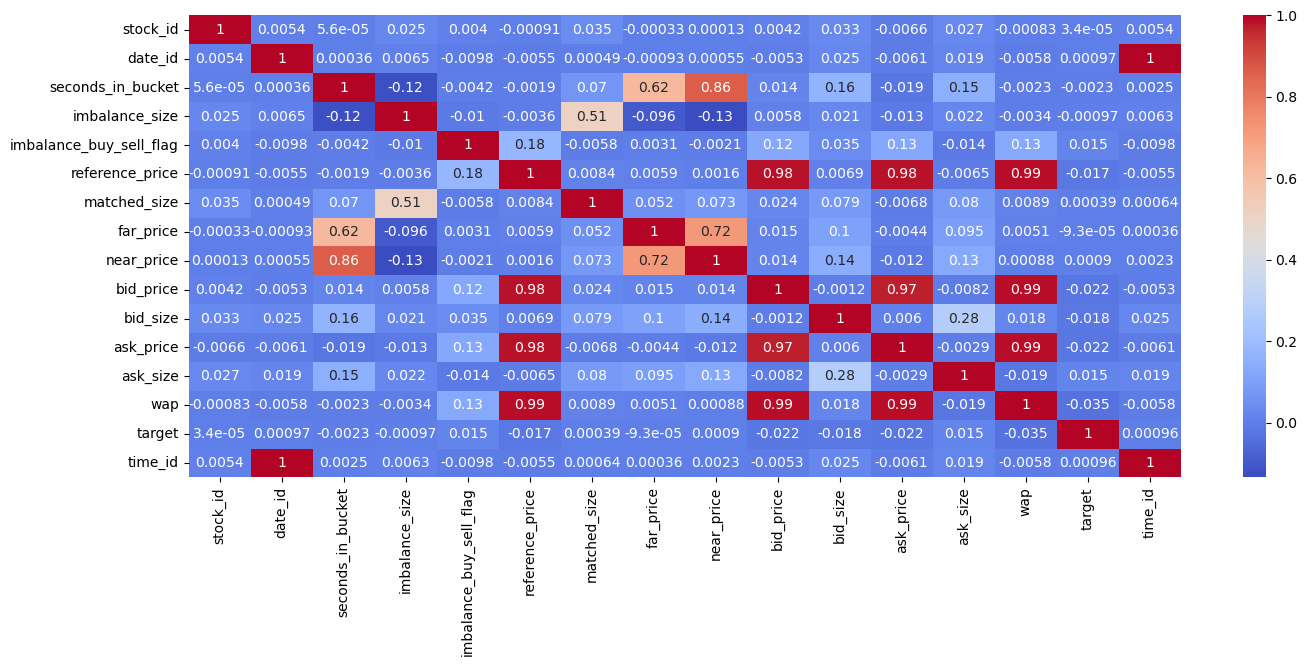

In [24]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(train_corr_matrix))
sns.heatmap(train_corr_matrix, cmap='coolwarm', annot=True)
plt.show()

The observed correlations within the dataset reveal key relationships among various features:

1. **ask_price and bid_price (0.972837):** The strong positive correlation is expected as they represent the most competitive sell (ask) and buy (bid) levels in the non-auction book. As one moves, the other often moves in the opposite direction to maintain a spread, resulting in a high correlation.

2. **far_price and near_price (0.717401):** The positive correlation is high because both features provide information about auction prices to non-auction traders. Far_price is a slightly tighter value of near_price, excluding continuous market orders.

3. **ask_price and reference_price (0.983654) | bid_price and reference_price (0.983654):** The high correlation indicates that traders often aim to place their buy (bid) or sell (ask) orders close to the current market price, which includes the reference_price, helping to maximize the matching of orders.

4. **seconds_in_bucket and near_price (0.862953):** The positive correlation suggests that traders closely monitor the passage of time ('seconds_in_bucket') to strategically place orders at or near the 'near_price' to maximize matched shares.

5. **bid_price and wap (0.989214) | ask_price and wap (0.988839):** The close alignment is logical since bid and ask prices represent the highest and lowest prices actively sought by buyers and sellers. These closely align with the Weighted Average Price (WAP), reflecting the average price of actual trades in the continuous market.

6. **reference_price and wap (0.988017):** The strong correlation indicates that trades executed close to the 'reference_price' significantly influence the WAP calculation, as the 'reference_price' is a critical level for traders during the closing auction.

#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts



In [25]:
from scipy.spatial.distance import euclidean
import numpy as np
import pandas as pd

def measure_distance(a_data, b_data):
    vals = [euclidean(a_data[i], b_data[i]) for i in range(len(a_data))]
    return vals

def calculate_average_distances(df, features):
    result = []
    
    for stock_id in df['stock_id'].unique():
        stock_data = df[df['stock_id'] == stock_id].reset_index(drop=True)
        stock_data_values = stock_data[features].values
        
        # Measure distance for all previous 10 days
        distances_before = np.apply_along_axis(
            lambda x: measure_distance(stock_data_values, np.roll(stock_data_values, x, axis=0)),
            axis=0,
            arr=np.arange(1, 11)
        )
        
        # Measure distance for all next 10 days
        distances_after = np.apply_along_axis(
            lambda x: measure_distance(stock_data_values, np.roll(stock_data_values, -x, axis=0)),
            axis=0,
            arr=np.arange(1, 11)
        )
        
        avg_distances = np.mean(np.column_stack([distances_before, distances_after]), axis=1)
        
        for i in range(len(stock_data)):
            result.append((stock_id, stock_data.loc[i, 'date_id'], avg_distances[i]))
    
    avg_distance_df = pd.DataFrame(result, columns=['stock_id', 'date_id', 'avg_distance'])
    return avg_distance_df


In [26]:
avg_df = calculate_average_distances(filtered_train, ['reference_price', 'wap', 'near_price', 'far_price'])

# Create an empty DataFrame to store autocorrelation results
autocorrelation_results = pd.DataFrame(columns=['stock_id', 'lag', 'autocorrelation'])

# Loop through each unique stock_id
for stock_id in avg_df['stock_id'].unique():
    stock_data = avg_df[avg_df['stock_id'] == stock_id]
    
    # Calculate autocorrelation for lags from -10 to +10
    for lag in range(-10, 11):
        if lag != 0:
            avg_corr = stock_data['avg_distance'].autocorr(lag)
            autocorrelation_results.loc[len(autocorrelation_results.index)] = {
                'stock_id': stock_id,
                'lag': lag,
                'autocorrelation': avg_corr
            }


In [27]:
autocorrelation_results.head(3)


,stock_id,lag,autocorrelation
0,0,-10,0.345858
1,0,-9,0.391850
2,0,-8,0.446425


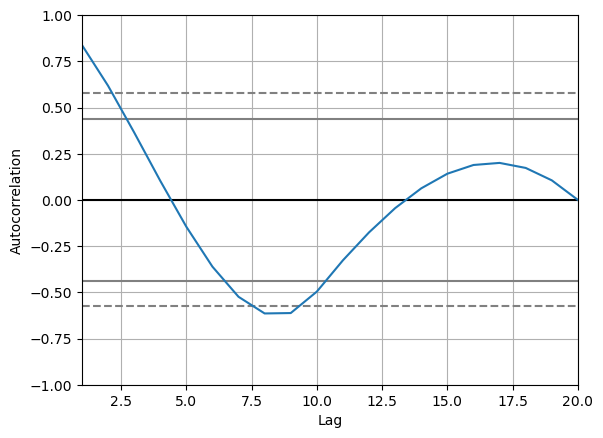

In [29]:
import matplotlib.pyplot as plt

autocorrelation_plot_data = autocorrelation_results.groupby(['lag'])['autocorrelation'].mean()

pd.plotting.autocorrelation_plot(autocorrelation_plot_data)
plt.show()


We can observe that the market exhibits a statistically significant level of autocorrelation based on the lag graph above.


In [30]:
# Calculate the average autocorrelation over all stocks
average_autocorrelation = autocorrelation_results['autocorrelation'].mean()
unusual_stocks = []

print("Stocks with unusually autocorrelate:")
print("stock_id \t pvalue")

for stock in autocorrelation_results['stock_id'].unique():
    df_stock = autocorrelation_results[autocorrelation_results['stock_id'] == stock]
    res = stats.ttest_1samp(df_stock['autocorrelation'], popmean=average_autocorrelation)
    
    if res.pvalue < 0.05:
        unusual_stocks.append(stock)
    
    print(f"{stock} \t\t {res.pvalue:.5f}")

print(f"Total number of stocks unusually autocorrelated: {len(unusual_stocks)}")


Stocks with unusually autocorrelate:
stock_id 	 pvalue
0 		 0.08734
1 		 0.11085
2 		 0.01933
3 		 0.08968
4 		 0.94818
5 		 0.83128
6 		 0.03670
7 		 0.43261
8 		 0.18251
9 		 0.00000
10 		 0.07311
11 		 0.00821
12 		 0.64196
13 		 0.13095
14 		 0.00020
15 		 0.12700
16 		 0.00185
17 		 0.16786
18 		 0.35033
19 		 0.21084
20 		 0.00554
21 		 0.05767
22 		 0.00000
23 		 0.36027
24 		 0.00000
25 		 0.02326
26 		 0.02406
27 		 0.05630
28 		 0.00000
29 		 0.07099
30 		 0.48714
31 		 0.00000
32 		 0.26813
33 		 0.00000
34 		 0.50969
35 		 0.16304
36 		 0.10543
37 		 0.07576
38 		 0.03180
39 		 0.09174
40 		 0.55893
41 		 0.87253
42 		 0.06630
43 		 0.01114
44 		 0.23471
45 		 0.42375
46 		 0.08627
47 		 0.41418
48 		 0.00673
49 		 0.12438
50 		 0.35953
51 		 0.38659
52 		 0.11929
53 		 0.43786
54 		 0.41434
55 		 0.22207
56 		 0.06497
57 		 0.39573
58 		 0.00981
59 		 0.22404
60 		 0.00000
61 		 0.53117
62 		 0.03246
63 		 0.00000
64 		 0.01455
65 		 0.00000
66 		 0.00000
67 		 0.06793
68 

Even though the market as a whole shows no discernible level of autocorrelation, we can observe that, of the 200 stocks included in the data, 76 of them are abnormally autocorrelated.


In [31]:
data_df = filtered_train.copy().set_index('date_id')  # Setting date_id as index to allow faster filtering
unique_dates = filtered_train['date_id'].unique()

# List to store all the dictionaries within the loop
res = []

# Loop through each unique date
for date in tqdm(unique_dates):
    date_data = data_df.loc[date]
    
    # Calculate the consensus for each stock on the current date
    date_consensus = date_data.groupby('stock_id')[['reference_price', 'near_price', 'far_price', 'wap']].agg('mean').reset_index()
    
    # Create unique pairs of stock_ids for the current date
    stock_pairs = list(combinations(date_consensus['stock_id'], 2))
    date_consensus = date_consensus.set_index('stock_id')  # Setting stock_id as index to allow faster filtering
    
    # Calculate the distance between consensus values for each stock pair
    for pair in stock_pairs:
        stock_a, stock_b = pair
        consensus_a = date_consensus.loc[stock_a]
        consensus_b = date_consensus.loc[stock_b]
        distance = euclidean(consensus_a, consensus_b)
        
        # Append the dictionary to the results list
        res.append({'stock_id_a': stock_a, 'stock_id_b': stock_b, 'date_id': date, 'distance': distance})

# Print the results
results = pd.DataFrame(res).reset_index(drop=True)


100%|████████████████████████████████████████████████████████████████████████████████| 481/481 [17:06<00:00,  2.13s/it]


In order to obtain stock pairs that exhibit consistent similarity, I calculate the average distance across all dates.
I now have an average distance between stock pairs for every date in the data.
I utilise a significance level of 5% to account for unusual similarities, meaning that the null hypothesis is rejected if the p-value is less than 0.05.


In [32]:
# Identify pairs of stocks that are unusually similar on a consistent basis
avg_distance_stocks = results.groupby(['stock_id_a', 'stock_id_b'])['distance'].agg('mean')
threshold = np.percentile(avg_distance_stocks, 5)
similar_pairs = avg_distance_stocks[avg_distance_stocks < threshold].reset_index()

# Output the results
print("Pairs of stocks that are unusually similar on a consistent basis:")
print(similar_pairs)


Pairs of stocks that are unusually similar on a consistent basis:
     stock_id_a  stock_id_b  distance
0             0          14  0.009903
1             0          83  0.009932
2             0         112  0.009378
3             0         142  0.010080
4             0         151  0.009819
..          ...         ...       ...
990         179         198  0.006250
991         186         198  0.009622
992         187         198  0.008142
993         193         198  0.008539
994         195         198  0.009619

[995 rows x 3 columns]


It is evident that, of the 200 x 199 potential stock pairs, only 995 pairs consistently exhibit unusual similarities. These shares may come from the same industry, such as several oil companies with comparable reference prices based on data, or pharmaceutical companies with comparable reference prices.
(c) Major stock sectors according to the source: Materials; Health Care. - Power. The consumer's choice. - Needs for everyday goods. - Manufacturing. - Services. The money. - Technology of information.
- Services for communication. - Property.
I set the K-means clusters to 11 because there are 11 major sectors.
I make use of all 16 features that are present in the dataset (with the exception of row_id, time_id, and date_id, which are not actually features).


In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    init="random",
    n_clusters=11,
    n_init=5,
    max_iter=300,
    random_state=42
)

df_numerical = filtered_train.copy().drop(['row_id', 'time_id', 'date_id'], axis=1)
data_consensus = df_numerical.groupby('stock_id').agg('mean').reset_index()
filtered_data = data_consensus.drop('stock_id', axis=1)

labels = kmeans.fit_predict(filtered_data)


In [34]:
from collections import Counter

value_counts = Counter(labels)
sorted_counts = sorted(value_counts.items(), key=lambda x: x[1], reverse=True)
sorted_counts


[(8, 35),
 (4, 31),
 (3, 29),
 (9, 28),
 (10, 23),
 (2, 14),
 (5, 13),
 (6, 10),
 (7, 9),
 (1, 6),
 (0, 2)]

I see three large clusters with over 25 stocks each (Clusters-4,-7, and 10).


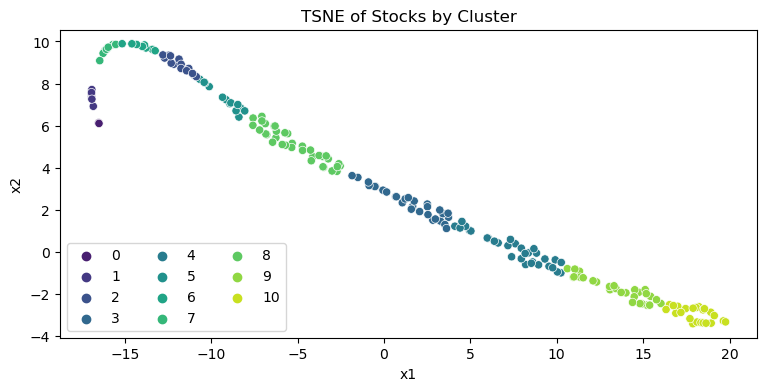

In [36]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

X_tsne = TSNE(n_components=2).fit_transform(filtered_data)
df_tsne = pd.DataFrame(X_tsne)
df_tsne['cluster'] = labels
df_tsne.columns = ['x1', 'x2', 'cluster']

plt.figure(figsize=(9, 4))
sns.scatterplot(data=df_tsne, x='x1', y='x2', hue='cluster', legend="full", alpha=1, palette=sns.color_palette('viridis', n_colors=len(df_tsne['cluster'].unique())))
plt.legend(loc="lower left", ncol=len(df_tsne.columns))
plt.title('TSNE of Stocks by Cluster')
plt.show()


Different clusters with several stocks within them are visible. We can group different stocks in their respective sectors (among the 11 previously described) thanks to the separation between the clusters.
Furthermore, the TSNE plot graphically shows that the largest clusters, which correspond to Clusters 4, 7, and 10, are the pink, orange, and yellow clusters. implying consistency with the results of K-means analysis.


#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts
- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts


In [37]:
def get_time_series(stock):
    stock_bin = filtered_train[filtered_train.stock_id == stock]
    ts_list = []
    
    for date in stock_bin['date_id'].unique():
        avg_px = stock_bin[stock_bin['date_id'] == date]['wap'].mean()
        ts_list.append({'date_id': date, 'wap': avg_px})
    
    time_series = pd.DataFrame(ts_list)
    time_series.index = time_series.date_id
    ts = time_series.drop("date_id", axis=1)
    
    return ts


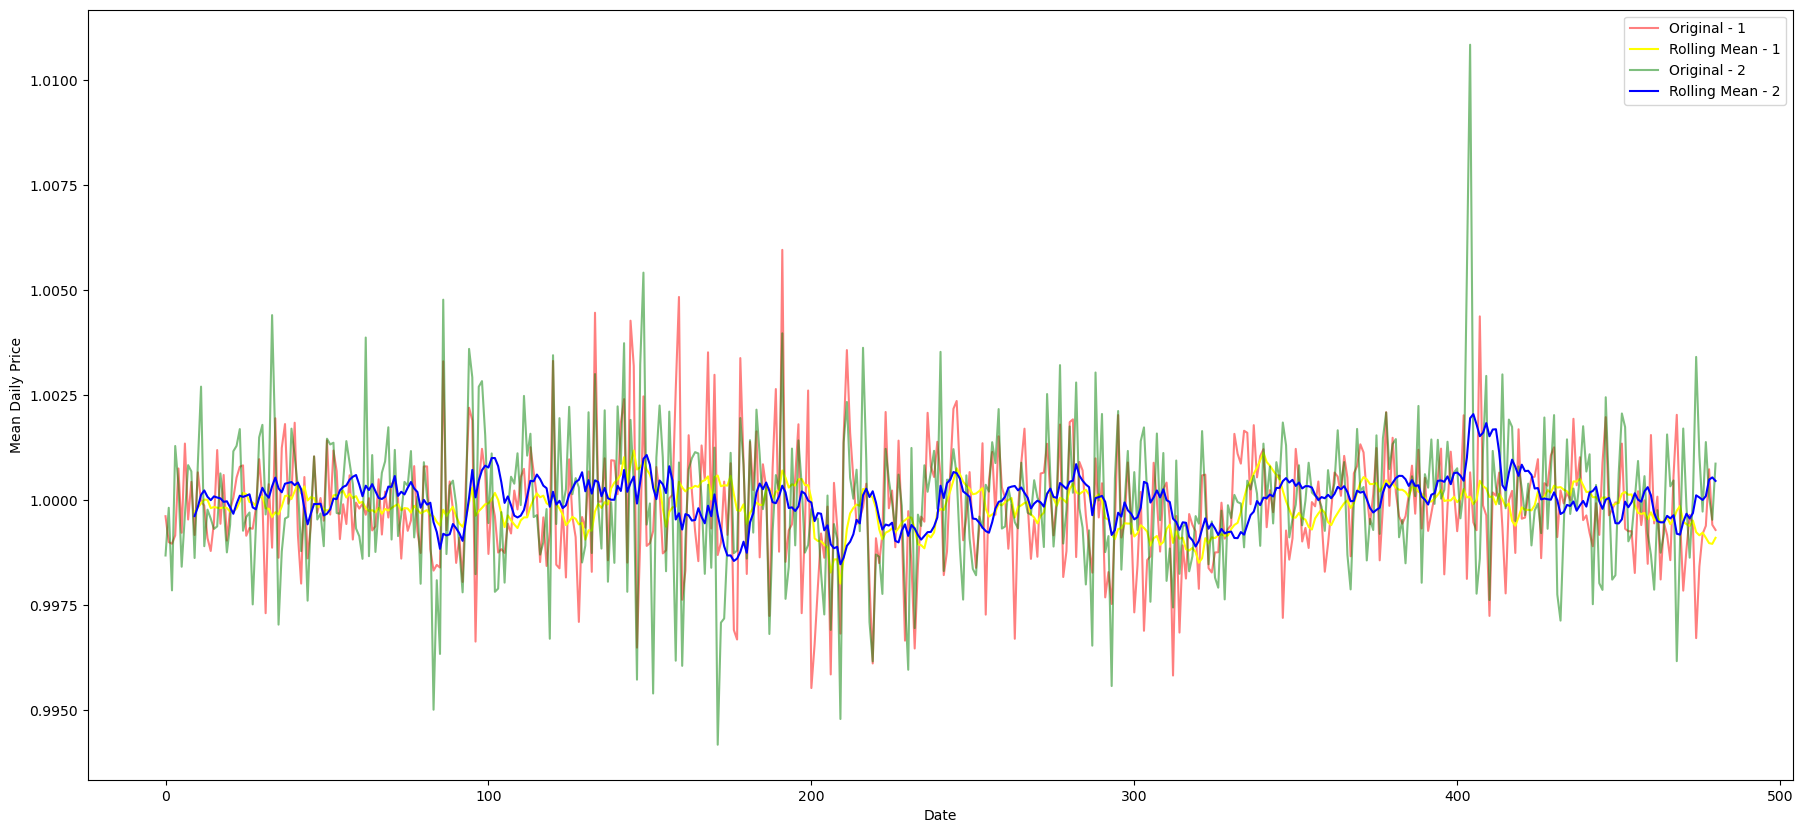

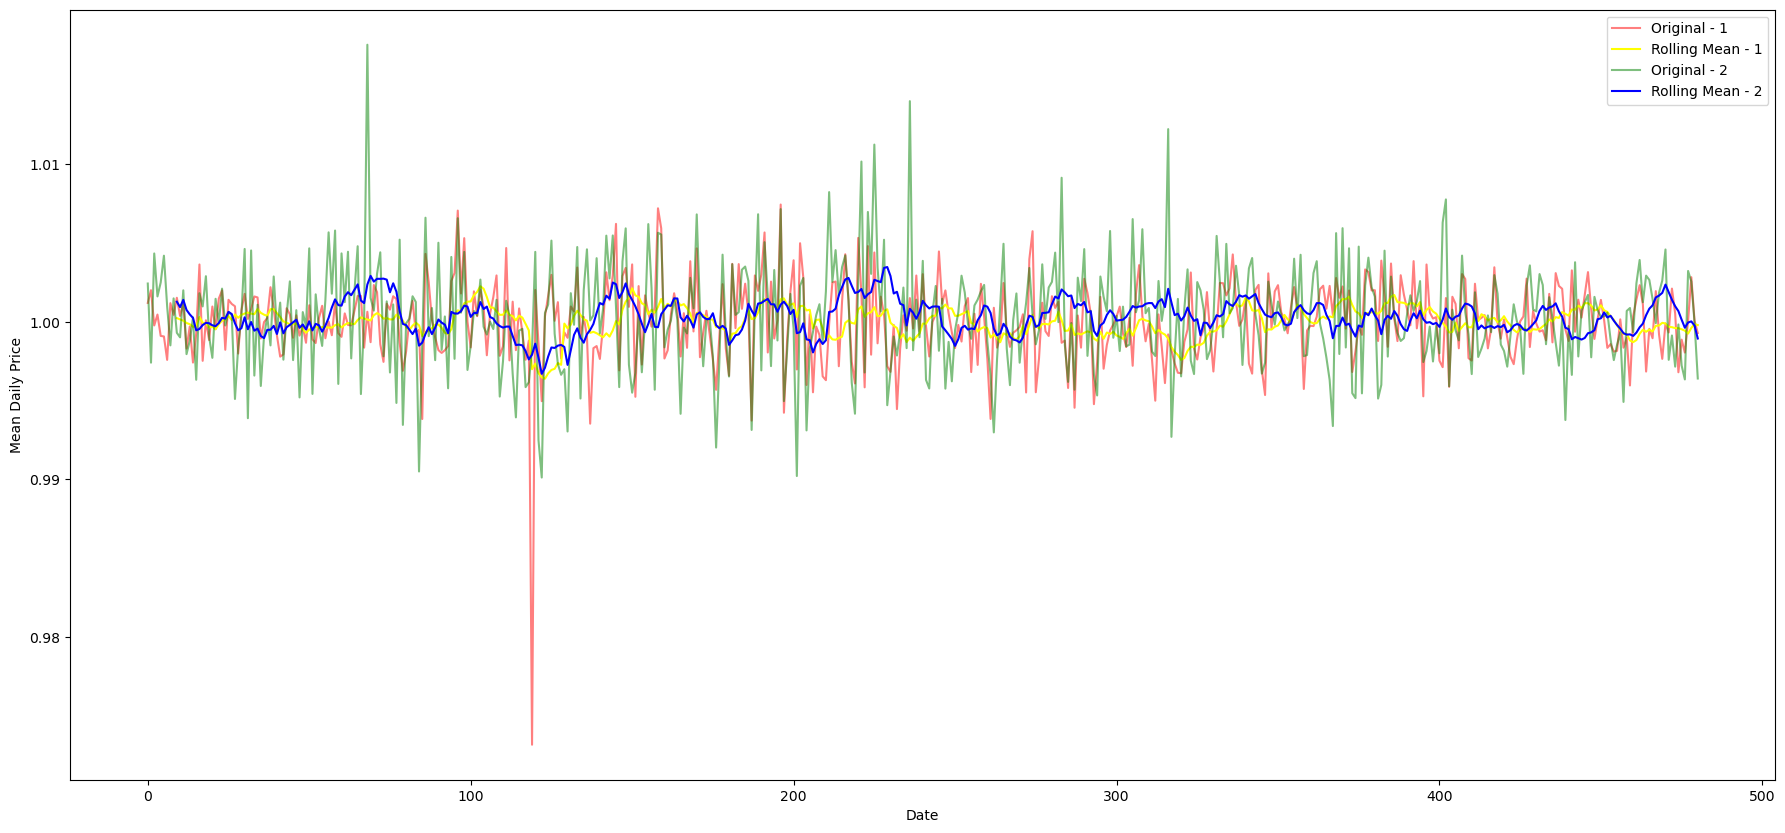

Test statistic: -11.731061837941352
p-value: 1.341358651009375e-21
Critical Values: {'1%': -3.4441047380903007, '5%': -2.867605550172837, '10%': -2.570000704119326}
Test statistic: -20.505962394512995
p-value: 0.0
Critical Values: {'1%': -3.4440471158221206, '5%': -2.867580197120949, '10%': -2.5699871918402777}
Test statistic: -21.67096037445715
p-value: 0.0
Critical Values: {'1%': -3.4440471158221206, '5%': -2.867580197120949, '10%': -2.5699871918402777}
Test statistic: -22.576884411789784
p-value: 0.0
Critical Values: {'1%': -3.4440471158221206, '5%': -2.867580197120949, '10%': -2.5699871918402777}


In [38]:
# Mean closing price for stocks 0, 26, 5, and 129
ts_0 = get_time_series(0)
ts_26 = get_time_series(26)
ts_5 = get_time_series(5)
ts_129 = get_time_series(129)

# Function to check Augmented Dickey-Fuller test
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

# Function to check mean and rolling mean
def check_mean(ts1, ts2):
    # Rolling statistics
    rolmean1 = ts1.rolling(window=10).mean()
    rolmean2 = ts2.rolling(window=10).mean()
    
    plt.figure(figsize=(22, 10))
    orig1 = plt.plot(ts1, color='red', label='Original - 1', alpha=0.5)
    mean1 = plt.plot(rolmean1, color='yellow', label='Rolling Mean - 1')
    orig2 = plt.plot(ts2, color='green', label='Original - 2', alpha=0.5)
    mean2 = plt.plot(rolmean2, color='blue', label='Rolling Mean - 2')
    
    plt.xlabel("Date")
    plt.ylabel("Mean Daily Price")
    plt.legend()
    plt.show()

# Check mean and rolling mean for stocks 0 and 26
check_mean(ts_0, ts_26)

# Check mean and rolling mean for stocks 5 and 129
check_mean(ts_5, ts_129)

# Check Augmented Dickey-Fuller test for stocks 0, 26, 5, and 129
check_adfuller(ts_0)
check_adfuller(ts_26)
check_adfuller(ts_5)
check_adfuller(ts_129)


Since the rolling mean for Stock 0|5|26|129 is somewhat centred around the daily price of 1, and the test statistic is less than the critical value, we can say that the time series is stationary, meaning that statistics like variance and mean are not affected by time. Plot 2 Reference
I attempt to utilise the advantages of network graphs for my second plot. Which correlations are strong enough to be shown as edges in the graph are determined by the threshold. You can find groups of stocks that move together and learn more about their interactions by examining the network graph.


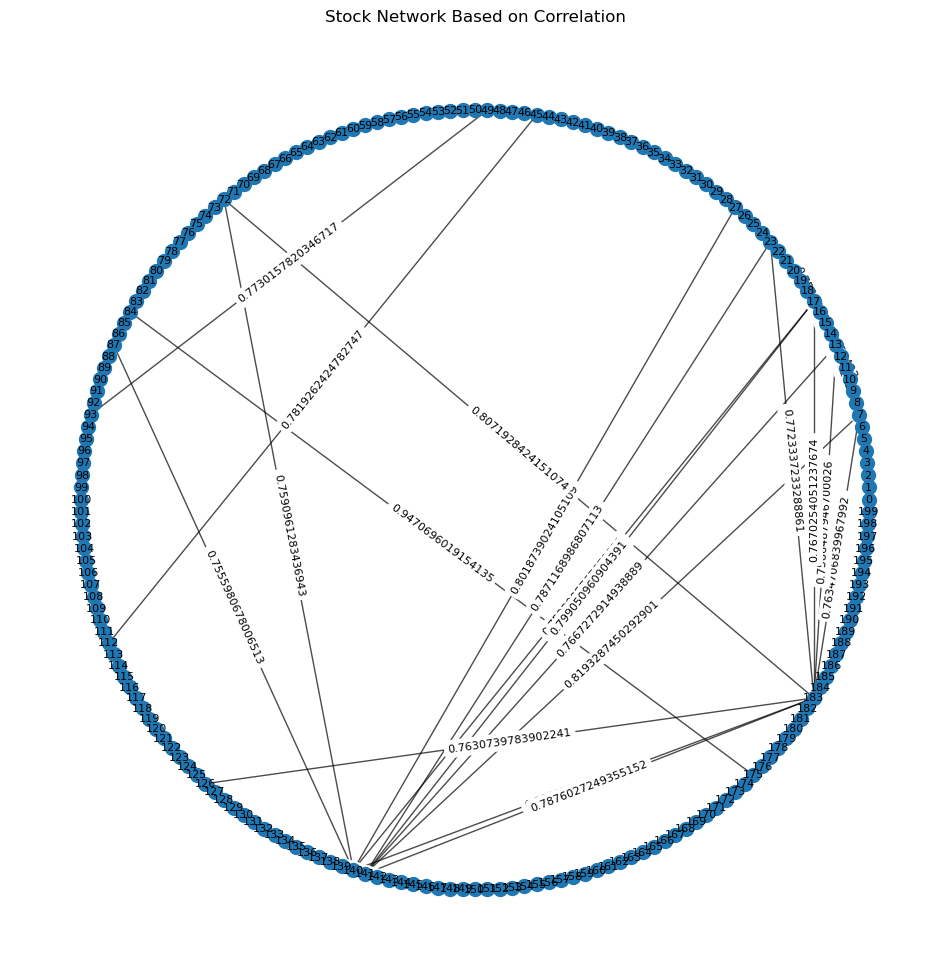

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

closing_prices = filtered_train.groupby(['date_id', 'stock_id'])['wap'].last().unstack()

# Calculate daily returns
daily_returns = closing_prices.pct_change().dropna()

# Calculate the correlation matrix
correlation_matrix = daily_returns.corr()

# Create a threshold for correlations to determine connections
threshold = 0.75  # You can adjust this threshold as needed

# Create a graph
G = nx.Graph()

# Add nodes (stocks) to the graph
G.add_nodes_from(daily_returns.columns)

# Add edges (connections) based on correlation threshold
for pair in combinations(daily_returns.columns, 2):
    stock1, stock2 = pair
    correlation = correlation_matrix.at[stock1, stock2]
    if abs(correlation) >= threshold:
        G.add_edge(stock1, stock2, weight=correlation)

# Plot the network graph
pos = nx.circular_layout(G)  # You can choose different layout algorithms

edge_labels = {(stock1, stock2): correlation['weight'] for stock1, stock2, correlation in G.edges(data=True)}
node_labels = {stock: stock for stock in G.nodes()}

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=100)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.7)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Stock Network Based on Correlation")
plt.axis('off')
plt.show()


Plot 3
My third plot uses a heatmap combined with dendograms. Dendograms' vertical lines, or heights, show how different or far apart stocks are from one another. The short lines show how similar the stocks are to one another. This is an important finding because it indicates which stocks have comparable price patterns or tend to move in tandem.


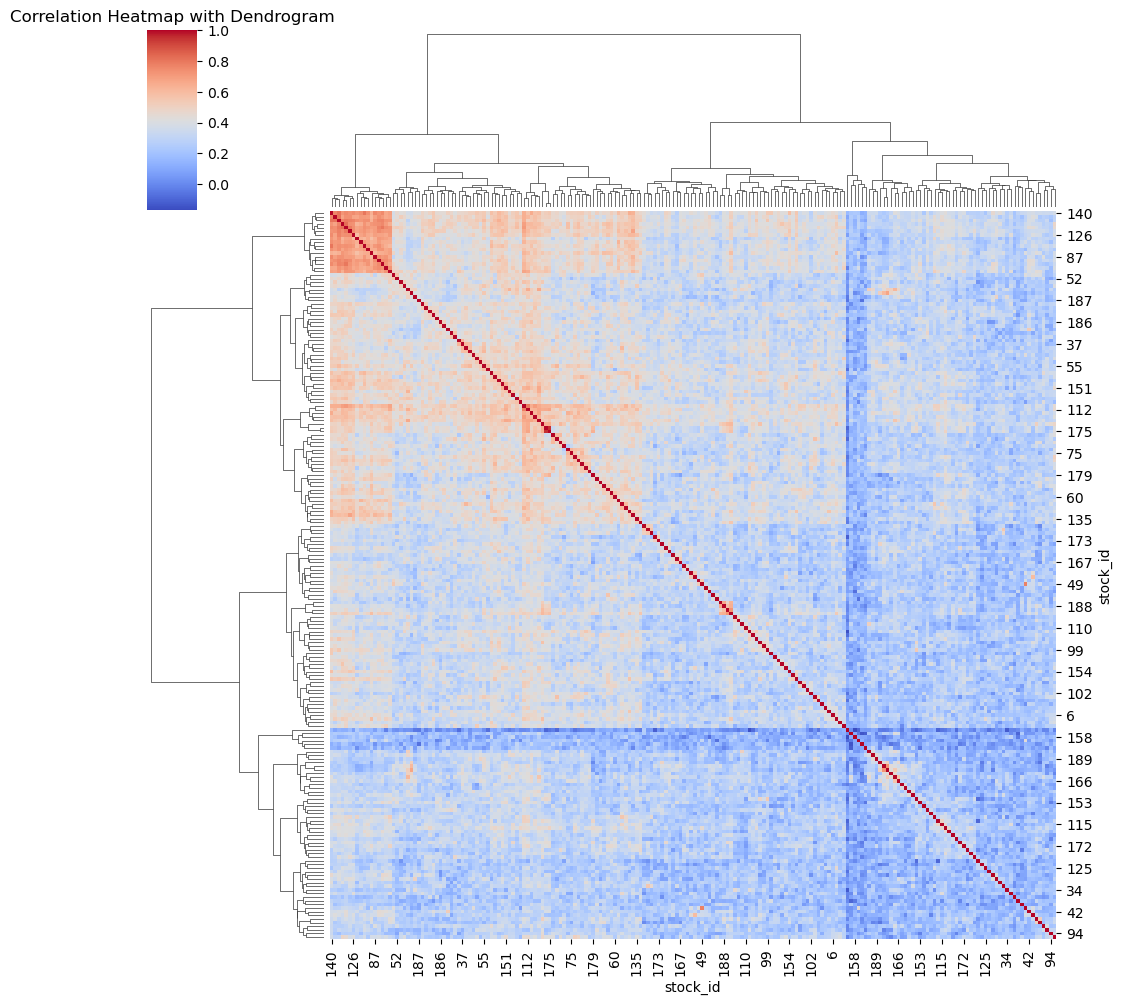

In [40]:
closing_prices = filtered_train.groupby(['date_id', 'stock_id'])['wap'].last().unstack()

# Calculate daily returns
daily_returns = closing_prices.pct_change().dropna()

# Calculate the correlation matrix
correlation_matrix = daily_returns.corr()

# Create a hierarchical clustering of stocks
clustered_correlation = sns.clustermap(correlation_matrix, cmap='coolwarm', method='ward', figsize=(10, 10))

# Plot the heatmap with the dendrogram
plt.title("Correlation Heatmap with Dendrogram")
plt.show()


In [41]:
closing_prices = filtered_train.groupby(['date_id', 'stock_id'])['wap'].last().unstack()

# Calculate daily returns
daily_returns = closing_prices.pct_change().dropna()

# Calculate the mean daily correlation between all stock pairs
correlations = []

# Iterate through all pairs of stocks
for stock1 in daily_returns.columns:
    for stock2 in daily_returns.columns:
        if stock1 != stock2:
            corr, _ = pearsonr(daily_returns[stock1], daily_returns[stock2])
            correlations.append(corr)

# Calculate the mean correlation
mean_correlation = np.mean(correlations)

# Perform a significance test to determine if the mean correlation is significantly different from zero
t_stat, p_value = stats.ttest_1samp(correlations, 0)

# Significance level (CI 95%)
alpha = 0.05

if p_value < alpha:
    print("The mean correlation is significantly different from zero, indicating that there is a correlation between stocks.")
else:
    print("The mean correlation is not significantly different from zero, suggesting that the relationships are essentially random.")


The mean correlation is significantly different from zero, indicating that there is a correlation between stocks.


(b) Using the movement of stocks over time, I determine the p-test. I run a permutation test on each stock and compare the p-value to the 95% Confidence Interval (CI).
My null hypothesis is that each stock has a small variance every day. If the p-value is less than 0.05, I can reject my null hypothesis and assert that the stock has a high variance.
High variance is the result of the stock's significant date-dependence fluctuations. Low Variance: Over time, there is less variance in the stock because it is less dependent on the date.


In [42]:
num_dates = len(filtered_train['date_id'].unique())
num_stocks = len(filtered_train['stock_id'].unique())
matrix = np.zeros([num_stocks, num_dates])

for i, stock in enumerate(filtered_train['stock_id'].unique()):
    stock_df = filtered_train[filtered_train['stock_id'] == stock]

    stock_vals = []
    for date in stock_df['date_id'].unique():
        date_df = stock_df[stock_df['date_id'] == date]
        stock_vals.append(date_df['target'].mean())

    if len(stock_vals) < num_dates:
        padding = num_dates - len(stock_vals)
        stock_vals = np.pad(stock_vals, (0, padding), 'constant')
    matrix[i] = stock_vals

mat = matrix.T.copy()  # Transpose to get (481 x 200) - dates in rows and stocks in columns
variance_0 = mat.var(axis=0)  # Variance over all the stocks

rng = np.random.default_rng()
counter = np.ndarray([num_stocks])
n_permutations = 10000

for i in range(n_permutations):
    perm_matrix = rng.permutation(mat, axis=1)
    variance_i = perm_matrix.var(axis=0)
    counter = np.where(variance_0 > variance_i, counter, counter + 1)

p_values = counter / n_permutations

print("Stocks which have significantly high variance, suggesting a dependence on date are:")
stocks = np.argwhere(p_values < 0.05).flatten()
pvalues = p_values[np.argwhere(p_values < 0.05)]

print(color.BOLD + "stock_id \t p-value" + color.END)

for i in range(len(stocks)):
    print(f" {stocks[i]} \t\t {pvalues[i][0]:5f}")


Stocks which have significantly high variance, suggesting a dependence on date are:
stock_id 	 p-value
 11 		 0.034000
 31 		 0.005400
 69 		 0.045800
 79 		 0.005000
 83 		 0.013500
 90 		 0.039300
 97 		 0.025700
 166 		 0.014300


#### Q5: Best prediction model, any approaches, 25 pts


First Approach: (Baseline) The linear regression method Using all of the train dataset's columns, I eliminate non-feature columns like row_id, time_id, date_id, and target in my first approach. To prevent them from dominating over other features, I normalise high magnitude features like matched_size and imbalance_size.
I utilise a model called Linear Regression to forecast the goal.


In [43]:
# Removing non-features from the dataframe
def remove_non_features(df):
    cols = [c for c in df.columns if c not in ['row_id', 'time_id', 'date_id', 'target']]
    df = df[cols]
    return df

def normalize_linear_regression(X):
    X['matched_size'] = X['matched_size'].apply(lambda x: np.log1p(x))
    X['imbalance_size'] = X['imbalance_size'].apply(lambda x: np.log1p(x))
    X['imbalance_buy_sell_flag'] = X['imbalance_buy_sell_flag'].apply(lambda x: 1 if x == 1 else 0)
    return X

df_feature = filtered_train.copy()
X = remove_non_features(df_feature)
y = df_feature['target']
X = normalize_linear_regression(X)

N_Folds = 5
mae_scores = []
kf = KFold(n_splits=N_Folds, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, y_pred)
    print(color.BOLD + f"Mean Absolute Error for Fold {fold+1}: {mae}" + color.END)
    mae_scores.append(mae)

average_mae_lr = np.mean(mae_scores)
print(color.BOLD + f"5 fold MAE: {average_mae_lr}" + color.END)


Mean Absolute Error for Fold 1: 6.3100202461769745
Mean Absolute Error for Fold 2: 6.290247170430626
Mean Absolute Error for Fold 3: 6.300436556847557
Mean Absolute Error for Fold 4: 6.303986275456071
Mean Absolute Error for Fold 5: 6.302509680949301
5 fold MAE: 6.301439985972107


Approch 2 (LightGBM): I employ feature engineering in my third approach, which combines a few features to create a feature that makes more sense in terms of domain. - imbalance_size_wap: establishes a correlation between imbalance and wap. - rolling_window: considers the last five values for imbalance_size by taking the rolling-average of window-size 5. - median_vol: This statistical measure of the trade sizes in continuous market orders is the median of the bid_size and ask_size for each stock.
- bid_size_diff: daily variation in the stock's bid_size. - ask_size_diff: variation in the daily ask_size of stock. - imbalance_ratio: This measure tells us something about the size of the pending order by comparing the imbalance_size and matched_size. imbalance: 0 indicates no imbalance, negative indicates a negative side, and positive indicates a buy side imbalance.
I use high magnitutes to normalise my features, just like in Approach (1), but I employ the conventional scalar method (xµ) in Approach (2).
I employ five-fold cross-validation with the Light Gradient Boosting Method.


In [44]:
def feature_engineering(df):
    median_vol = df_feature.groupby('stock_id')['bid_size'].median() + df_feature.groupby('stock_id')['ask_size'].median()
    df['imbalance_size_wap'] = df['imbalance_size'] * df['wap']
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
    df['imbalance_ratio'].fillna(0, inplace=True)
    window_size = 5
    df['rolling_window'] = df.groupby('stock_id')['imbalance_size'].rolling(window=window_size).mean().reset_index(0, drop=True)
    df['rolling_window'].fillna(df['rolling_window'].median(), inplace=True)
    df['median_vol'] = df['stock_id'].map(median_vol.to_dict())
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
    df["imbalance"] = df["imbalance_size"] * df["imbalance_buy_sell_flag"]
    df['bid_size_diff'] = df[["stock_id", "date_id", "bid_size"]].groupby(["stock_id", "date_id"]).diff()
    df['ask_size_diff'] = df[["stock_id", "date_id", "ask_size"]].groupby(["stock_id", "date_id"]).diff()
    df.fillna(0, inplace=True)
    return df

# Removing features which are used in feature engineering, as they would be highly correlated with each other
def remove_non_features_cols(df):
    cols = [c for c in df.columns if c not in ['row_id', 'time_id', 'date_id', 'imbalance_size', 'wap', 'imbalance_buy_sell_flag', 'target']]
    df = df[cols]
    return df

def scale(x):
    return (x - x.mean()) / (x.std() + 1e-8)

def normalize_features(X):
    scalar = StandardScaler()
    X['matched_size'] = scale(X['matched_size'])
    X['imbalance_size_wap'] = scale(X['imbalance_size_wap'])
    X['rolling_window'] = scale(X['rolling_window'])
    X['median_vol'] = scale(X['median_vol'])
    X["imbalance"] = scale(X['imbalance'])
    X["bid_size_diff"] = scale(X['bid_size_diff'])
    X["ask_size_diff"] = scale(X['ask_size_diff'])
    return X

df_feature = filtered_train.copy()
df_feature = feature_engineering(df_feature)
X = normalize_features(remove_non_features_cols(df_feature)).fillna(0)
y = df_feature['target']

N_Folds = 5
mae_scores = []
kf = KFold(n_splits=N_Folds, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    lgbm_model = lgbm.LGBMRegressor(objective='mae', n_estimators=500, random_state=42)
    lgbm_model.fit(X_train, y_train)
    y_pred = lgbm_model.predict(X_valid)

    mae = mean_absolute_error(y_valid, y_pred)
    print(color.BOLD + f"Mean Absolute Error for Fold {fold + 1}: {mae}" + color.END)
    mae_scores.append(mae)

average_mae_lgbm = np.mean(mae_scores)
print(color.BOLD + f"5 fold MAE: {average_mae_lgbm}" + color.END)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4026
[LightGBM] [Info] Number of data points in the train set: 4160478, number of used features: 17
[LightGBM] [Info] Start training from score -0.060201
Mean Absolute Error for Fold 1: 6.249074593307139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4026
[LightGBM] [Info] Number of data points in the train set: 4160478, number of used features: 17
[LightGBM] [Info] Start training from score -0.060201
Mean Absolute Error for Fold 2: 6.233051784283074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4026
[LightGBM] [In

Approch 3 (Neural Networks): I use the engineered features in a manner akin to Approch 2, as it has been observed that feature engineering improves performance (2). The method differs in that I use a neural network as my model.
There are four hidden layers in the neural network, each with a size of 256. The target value that the model must predict is the final output. Mean Absolute Error, or L1 loss, is what I use. Adam is the optimizer, and his learning rate is 0.001 Modelling


In [51]:
layers = [256, 256, 256, 256]

class ClosingTargetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(input_size, layers[0]),
            nn.ReLU()
        )
        for i in range(len(layers)-1):
            self.linear.append(nn.Linear(layers[i], layers[i+1]))
            self.linear.append(nn.ReLU())
        self.linear.append(nn.Linear(layers[-1], 1))

    def forward(self, x):
        output = self.linear(x)
        return output

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(tqdm(dataloader, total=num_batches, desc='Training', unit='batch')):
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return train_loss.detach().cpu().numpy() / num_batches

def test_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).detach().cpu().numpy()
        scheduler.step(test_loss)
    return test_loss / num_batches

def predict(X, model):
    model.eval()
    with torch.no_grad():
        pred = model(X)
    return pred.detach().cpu().numpy().flatten()


In [55]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split, TensorDataset
from tqdm import tqdm

# Define the ClosingTargetModel
class ClosingTargetModel(nn.Module):
    def __init__(self, input_size, layers):
        super(ClosingTargetModel, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(input_size, layers[0]),
            nn.ReLU()
        )
        for i in range(len(layers)-1):
            self.linear.add_module(f"linear_{i}", nn.Linear(layers[i], layers[i+1]))
            self.linear.add_module(f"relu_{i}", nn.ReLU())
        self.linear.add_module("output", nn.Linear(layers[-1], 1))

    def forward(self, x):
        return self.linear(x)

# Initialize the model with input_size and layers
model = ClosingTargetModel(input_size, layers)

# Initialize the weights and biases
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Apply initialization to the model
model.apply(init_weights)

# Define your loss function, optimizer, and scheduler
loss_fn = nn.L1Loss()
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min')

# Create dummy data loader (replace with your actual data loader)
dummy_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
for epoch in range(epochs):
    train_loss = train_loop(dummy_dataloader, model, loss_fn, optimizer)
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss}")

# Test loop (replace dummy_test_dataloader with your actual test data loader)
test_loss = test_loop(dummy_test_dataloader, model, loss_fn)
print(f"Test Loss: {test_loss}")

# Make predictions (replace X with your input data)
with torch.no_grad():
    X_tensor = torch.tensor(X, dtype=torch.float32)
    predictions = predict(X_tensor, model)
    print(predictions)


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [07:31<00:00, 171.00batch/s]


Epoch 1, Training Loss: 7.18307463372929


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [08:48<00:00, 146.17batch/s]


Epoch 2, Training Loss: 6.389219302563571


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [08:42<00:00, 147.84batch/s]


Epoch 3, Training Loss: 6.391047012837286


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [08:50<00:00, 145.43batch/s]


Epoch 4, Training Loss: 6.389195823671904


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [09:23<00:00, 137.06batch/s]


Epoch 5, Training Loss: 6.38921404005337


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [09:26<00:00, 136.35batch/s]


Epoch 6, Training Loss: 6.389197847714289


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [09:30<00:00, 135.37batch/s]


Epoch 7, Training Loss: 6.389175583248054


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [09:15<00:00, 138.96batch/s]


Epoch 8, Training Loss: 6.3892213266059565


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [09:22<00:00, 137.35batch/s]


Epoch 9, Training Loss: 6.389202300607536


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [09:30<00:00, 135.35batch/s]


Epoch 10, Training Loss: 6.3891998717566745


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [09:28<00:00, 135.83batch/s]


Epoch 11, Training Loss: 6.3891634389937435


Training: 100%|██████████████████████████████████████████████████████████████| 77197/77197 [09:20<00:00, 137.61batch/s]


Epoch 12, Training Loss: 6.389252092050209


Training:  23%|██████████████▍                                               | 17960/77197 [02:07<07:00, 140.94batch/s]


KeyboardInterrupt: 

It was not feasible to use 5-fold cross validation with 5 epochs for each fold in an inventive manner. In order to train the model and obtain the average mean absolute error, I use five epochs. The average MAE is included in the final results table by me.
Additionally, I've added early stopping, which means that the training ends right away if the loss value does not increase for three consecutive epochs. This idea helps us conserve resources when we train on massive amounts of data.


In [56]:
epochs = 5
patience = 3
early_stop_count = 0
history = pd.DataFrame([], columns=["epoch", "train_loss", "test_loss", "lr"])

for epoch in range(epochs):
    current_lr = optimizer.param_groups[0]['lr']
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    print(f"Epoch {epoch + 1:<5d} Train: {train_loss:<4f} | Test: {test_loss:<4f}")

    if test_loss >= history["test_loss"].min():
        early_stop_count += 1
        if early_stop_count == patience:
            history.loc[len(history), :] = [epoch + 1, train_loss, test_loss, current_lr]
            print("Early stopping triggered")
            break
    else:
        early_stop_count = 0
        history.loc[len(history), :] = [epoch + 1, train_loss, test_loss, current_lr]

history


Training: 100%|█████████████████████████████████████████████████████████████████| 9649/9649 [03:08<00:00, 51.07batch/s]


Epoch 1     Train: 6.389196 | Test: 6.375531


Training: 100%|█████████████████████████████████████████████████████████████████| 9649/9649 [03:25<00:00, 46.96batch/s]


Epoch 2     Train: 6.389177 | Test: 6.375481


Training: 100%|█████████████████████████████████████████████████████████████████| 9649/9649 [03:21<00:00, 47.81batch/s]


Epoch 3     Train: 6.389168 | Test: 6.375500


Training: 100%|█████████████████████████████████████████████████████████████████| 9649/9649 [03:27<00:00, 46.51batch/s]


Epoch 4     Train: 6.389150 | Test: 6.375518


Training: 100%|█████████████████████████████████████████████████████████████████| 9649/9649 [03:28<00:00, 46.33batch/s]


Epoch 5     Train: 6.389163 | Test: 6.375486
Early stopping triggered


,epoch,train_loss,test_loss,lr
0,1,6.389196,6.375531,0.001
1,2,6.389177,6.375481,0.001
2,5,6.389163,6.375486,0.001


In [57]:
average_mae_nn = history['test_loss'].mean()
result_df = pd.DataFrame([
    {"Model": "Linear Regression", "Mean Absolute Error": average_mae_lr, "Feature Eng. Done": "No"},
    {"Model": "Light Gradient Boosting", "Mean Absolute Error": average_mae_lgbm, "Feature Eng. Done": "Yes"},
    {"Model": "Neural Network", "Mean Absolute Error": average_mae_nn, "Feature Eng. Done": "Yes"}
])
result_df

,Model,Mean Absolute Error,Feature Eng. Done
0,Linear Regression,6.301440,No
1,Light Gradient Boosting,6.242213,Yes
2,Neural Network,6.375499,Yes
